Processing α = 0.5
Processing α = 1.0
Processing α = 2.0
Processing α = 3.0
Processing α = 4.0
Processing α = 5.0
Processing α = 6.0
Processing α = 7.0


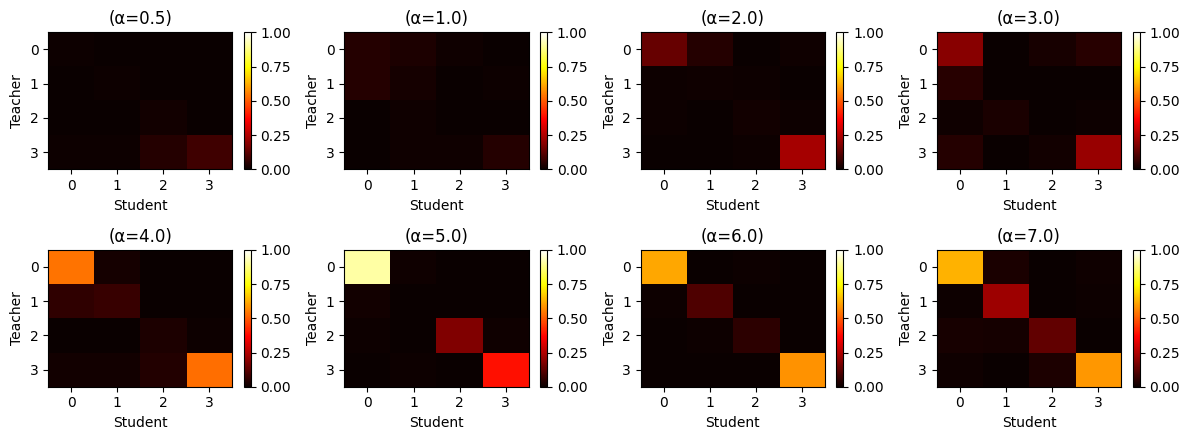

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[1], 'GPU')
import hmc2
from scipy.sparse import csr_array
from scipy.sparse.csgraph import min_weight_full_bipartite_matching as match

d = 200
k = 4
alpha_values = [ 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Delta = 0.1
v = tf.constant([-3.0, -1.0, 1.0, 3.0], dtype=tf.float32)
v -= tf.reduce_mean(v)
v /= tf.norm(v)
prior = 'gauss'

#sig = lambda x: (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6
sig = lambda x: x + (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6
#sig = lambda x: tf.sign(x)
#sig = tf.nn.tanh

mean_diagonal_overlaps_info = []

def fix_teacher_order(S, v):
    """
    Sort the rows of the alignment matrix S according to increasing v (teacher readout weights).
    """
    idx = np.argsort(v)
    return S[idx, :]


params = {
    'step_size': 0.01,
    'num_leapfrog_steps': 10,
    'num_adaptation_steps': 2000,
    'num_post_adapt_steps': 4
}

# subplot

n_1 = len(alpha_values)
assert n_1 <= 8, "You can only plot up to 8 alpha values in a 2x4 grid."

fig, axes = plt.subplots(2, 4, figsize=(12, 4.5), tight_layout=True)  
axes = axes.reshape(2, 4)  

for i, alpha in enumerate(alpha_values):
    print(f"Processing α = {alpha}")
    
    # Generate data
    W0, X, Y, v = hmc2.data_generate(d, k, alpha, Delta, sig, v)
    W_ = tf.random.normal((k, d), dtype=tf.float32)
    
    # Posterior sampling
    Ws_info = hmc2.hmc(params, W0, X, Y, v, k, alpha, Delta, sig, show_acceptance_rate=False, show_adaptation_steps=True)
    # Final samples
    Wi = Ws_info[-1]

    # Compute alignment matrices
    Si = fix_teacher_order((W0 @ tf.transpose(Wi) / d).numpy(), v.numpy())
    Si_sq = Si**2

    row, col_base = divmod(i, 2)
    col = 2 * col_base
    # Plot informative
    ax1 = axes.flatten()[i]
    im1 = ax1.imshow(Si_sq, cmap='hot', aspect='auto', vmin=0, vmax=1)
    ax1.set_title(f'(α={alpha})')
    ax1.set_xlabel('Student')
    ax1.set_ylabel('Teacher')
    plt.colorbar(im1, ax=ax1)
plt.subplots_adjust(top=0.92)
plt.savefig("Overlap_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

Training for alpha = 0.5
Training for alpha = 1.0
Training for alpha = 2.0
Training for alpha = 3.0
Training for alpha = 4.0
Training for alpha = 5.0
Training for alpha = 6.0
Training for alpha = 7.0


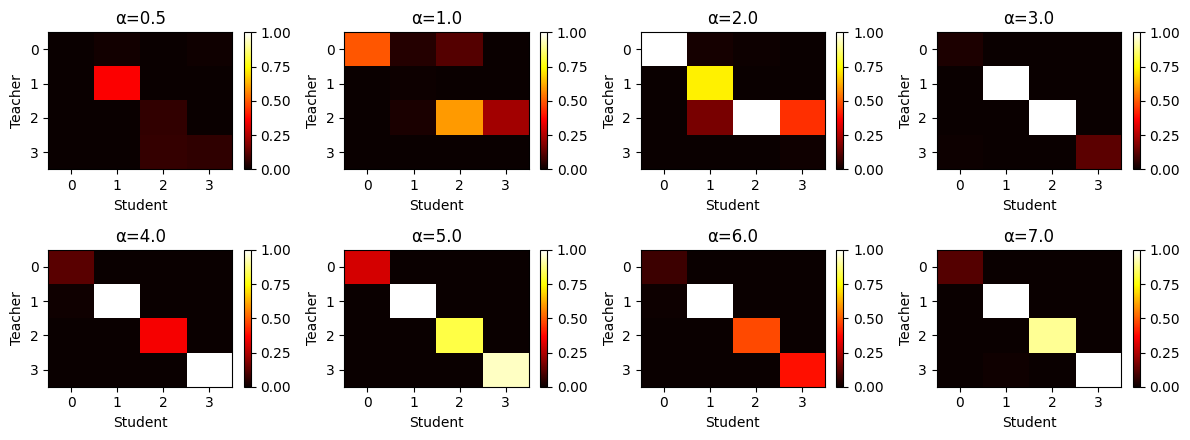

In [22]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[1], 'GPU')

import hmc2

from scipy.sparse import csr_array
from scipy.sparse.csgraph import min_weight_full_bipartite_matching as match

def per(M):
    size, _ = M.shape
    per_index = match(csr_array(M), maximize=True)
    per_matrix = np.zeros((size, size), dtype=int)
    per_matrix[per_index[0], per_index[1]] = 1
    M_ = per_matrix.T @ M
    return M_

def fix_teacher_order(S, v):
    """
    Fix row order based on sorted teacher readout weights v.
    """
    idx = np.argsort(v)
    return S[idx, :]



# tecaher activation
#sig_t = lambda x: tf.sign(x)
sig_t = lambda x: x + (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6

# ------------------------------
# Data generation (teacher)
# ------------------------------
def data_generate(d, k, alpha, Delta, sig_t, v):
    c_k, c_d = 1/np.sqrt(k), 1/np.sqrt(d)
    n = int((alpha*d**2)/np.sqrt(d))
    W0 = tf.random.normal((k, d), dtype=tf.float32)
    X = tf.random.normal((d, n), dtype=tf.float32)
    Z = tf.random.normal((n,), dtype=tf.float32)
    M = sig_t(W0 @ X * c_d)
    Y = tf.tensordot(v, M, axes=1) * c_k + tf.sqrt(Delta) * Z
    return W0, X, Y, v

# ------------------------------
# Student training
# ------------------------------
def train_student(X, Y, k, d, v, Delta, sig, lr=0.05, steps=1000, track_alignments=False, W0=None):
    c_k, c_d = 1/np.sqrt(k), 1/np.sqrt(d)
    W = tf.Variable(tf.random.normal((k, d), dtype=tf.float32))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    snapshots = []

    for step in range(steps):
        with tf.GradientTape() as tape:
            M = sig(W @ X * c_d)
            Y_hat = tf.tensordot(v, M, axes=1) * c_k
            loss = tf.reduce_mean((Y_hat - Y)**2) / (2 * Delta)
        grads = tape.gradient(loss, [W])
        optimizer.apply_gradients(zip(grads, [W]))

        if track_alignments and step % 100 == 0:
            S = (W0 @ tf.transpose(W) / d).numpy()
            snapshots.append(S)

    if track_alignments:
        return W.numpy(), snapshots
    else:
        return W.numpy()

# ------------------------------
# Experiment setup
# ------------------------------
d, k = 150, 4
#alpha_values = [0.2,1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.5]
alpha_values = [ 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Delta = 0.5
v = tf.constant([-3, -1, 1, 3], dtype=tf.float32)
v = v - tf.reduce_mean(v)
v /= tf.norm(v)

sig = lambda x: x + (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6
alignments = []
alpha_6_snapshots = []
mean_diagonal_overlaps_gd = []


for alpha in alpha_values:
    print(f"Training for alpha = {alpha}")
    W0, X, Y, _ = data_generate(d, k, alpha, Delta, sig, v)

    if alpha == 6:
        W_student, alpha_6_snapshots = train_student(
            X, Y, k, d, v, Delta, sig, track_alignments=True, W0=W0)
    else:
        W_student = train_student(X, Y, k, d, v, Delta, sig)

    S = W0 @ tf.transpose(W_student) / d
    alignments.append(S.numpy()**2)
    
    S_gd = S**2

fig, axes = plt.subplots(2, 4, figsize=(12, 4.5), tight_layout=True)
axes = axes.flatten()

for i, (S, alpha) in enumerate(zip(alignments, alpha_values)):
    ax = axes[i]
    
    # Fix teacher order based on v = [-3, -1, 1, 3]
    S_fixed = fix_teacher_order(S, v.numpy())
    
    # Apply Hungarian matching (optimal student permutation)
    S_aligned_1 = per(S_fixed)
    S_aligned = S_aligned_1**2
    mean_diag_gd = np.mean(np.diag(S_aligned))
    mean_diagonal_overlaps_gd.append(mean_diag_gd)

    # Plot
    im = ax.imshow(S_aligned, cmap='hot', aspect='auto', vmin=0, vmax=1)
    ax.set_xlabel('Student')
    ax.set_ylabel('Teacher')
    ax.set_title(f"α={alpha}")
    plt.colorbar(im, ax=ax)

plt.subplots_adjust(top=0.92)
plt.savefig("Overlap_sgd.png", dpi=300, bbox_inches='tight')

plt.show()

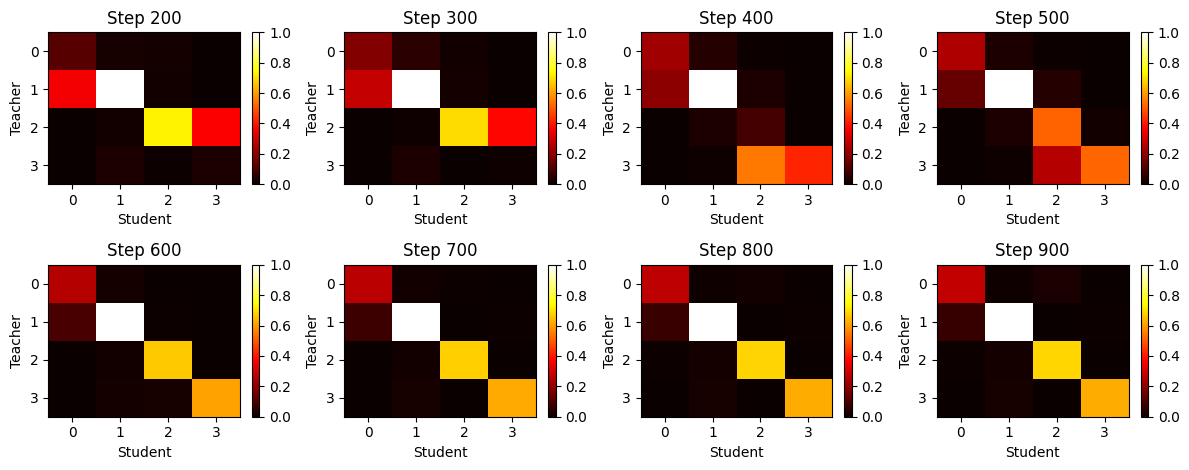

In [23]:
# Plot evolution of alignment matrix for alpha = 6 (from step 200 to 1000)
start_index = 2  # step 200 is the 3rd snapshot (0-indexed: 0,100,200 → index2)
end_index = 10   # step 900 is the 10th snapshot (0-indexed: 900 is index9)

selected_snapshots = alpha_6_snapshots[start_index:end_index]  # 8 snapshots (200-900)
num_snapshots = len(selected_snapshots)

fig, axes = plt.subplots(2, 4, figsize=(12, 4.8), tight_layout=True)
axes = axes.flatten()

for i, S in enumerate(selected_snapshots):
    ax = axes[i]
    aligned = per(S)
    step_number = (start_index + i) * 100  # Calculate actual step (200, 300, ..., 900)
    im = ax.imshow(aligned**2, cmap='hot', aspect='auto', vmin=0, vmax=1)
    ax.set_title(f"Step {step_number}")
    ax.set_xlabel("Student")
    ax.set_ylabel("Teacher")
    plt.colorbar(im, ax=ax)

# Hide any unused subplots (we have exactly 8 snapshots so this won't execute)
for j in range(num_snapshots, 8):
    fig.delaxes(axes[j])

#plt.suptitle("Evolution of Alignment Matrix for α = 6 (Steps 200–900)", fontsize=16)
plt.savefig("alignment_evolution_alpha6_200_900_1.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
import tensorflow as tf
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[1], 'GPU')
import math
import numpy as np
from numpy.polynomial.hermite_e import hermegauss
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import hmc2 

I0000 00:00:1755042422.386426 1726896 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14079 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6


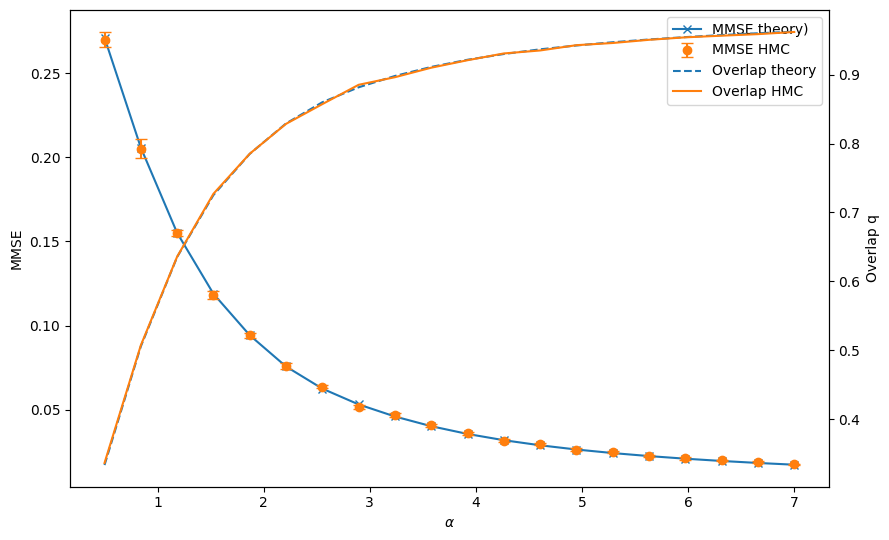

In [4]:
np.random.seed(123)
tf.random.set_seed(123)

N_GH = 150
xs, ws = hermegauss(N_GH)

def Ez(f):
    """E[f(Z)] for Z~N(0,1) using Gauss–Hermite."""
    return float(np.sum(ws * f(xs)) / np.sqrt(2*np.pi))

def P_y_given_u(y, u, sig, q, Delta):
    inner = lambda v: np.exp(-(y - sig(np.sqrt(q)*u + np.sqrt(1-q)*v))**2 / (2*Delta))
    return Ez(inner) / np.sqrt(2*np.pi*Delta)

def H_Y_u(u, sig, q, Delta):
    pad = 8.0
    ymin = -1 - pad*np.sqrt(Delta)
    ymax =  1 + pad*np.sqrt(Delta)
    p  = lambda y: P_y_given_u(y, u, sig, q, Delta)
    integrand = lambda y: -p(y) * np.log(p(y) + 1e-16)
    val, _ = quad(integrand, ymin, ymax, epsabs=1e-7, epsrel=1e-6, limit=200)
    return val

H_Y_u_vec = np.vectorize(H_Y_u, otypes=[float])

def H_Y_U(sig, q, Delta):
    return Ez(lambda u: H_Y_u_vec(u, sig, q, Delta))

def make_dH_dq(sig, Delta, smoothing_grid=61, smooth=True):
    if not smooth:
        def diff_centered(f, x, eps=1e-3):
            x = float(np.clip(x, 1e-6, 1-1e-6))
            if x < 1e-6 + eps:
                return (f(x + eps) - f(x)) / eps
            if x > 1 - 1e-6 - eps:
                return (f(x) - f(x - eps)) / eps
            return (f(x + eps) - f(x - eps)) / (2*eps)
        return lambda q: diff_centered(lambda qq: H_Y_U(sig, qq, Delta), q, 1e-3)

    qs = np.linspace(1e-4, 1-1e-4, smoothing_grid)
    HY = np.array([H_Y_U(sig, q, Delta) for q in qs], dtype=float)
    spline = UnivariateSpline(qs, HY, s=1e-6, k=3)
    dspline = spline.derivative()
    return lambda q: float(dspline(float(np.clip(q, 1e-6, 1-1e-6))))

def He_rec(x, n):
    if n == 0:
        return np.ones_like(x)
    if n == 1:
        return x
    a, b = np.ones_like(x), x
    for k in range(2, n+1):
        a, b = b, x*b - (k-1)*a
    return b

def hermite_coeffs(sig_np, nmax):
    coeffs = np.empty(nmax+1, dtype=float)
    for n in range(nmax+1):
        coeffs[n] = Ez(lambda z: sig_np(z) * He_rec(z, n))
    return coeffs

def make_h_poly(sig_np, nmax=80):
    coeffs = hermite_coeffs(sig_np, nmax)
    facs = np.array([math.factorial(i) for i in range(nmax+1)], dtype=float)
    terms = (coeffs*coeffs) / facs  
    def hq(q):
        q = float(np.clip(q, 0.0, 1.0))
        powers = np.array([q**i for i in range(len(terms))], dtype=float)
        return float(np.dot(terms, powers))
    return hq

def mmse_theory_curve(alpha_values, Delta, sig_np, h_poly,
                      q_init=1e-4, eta=0.35, max_iter=600, tol=5e-5,
                      use_spline_derivative=True):
    dH = make_dH_dq(sig_np, Delta, smooth=use_spline_derivative)
    mmse_list, q_list = [], []
    q_prev = float(q_init)
    for a in alpha_values:
        q = float(q_prev)
        for _ in range(max_iter):
            r = -2.0 * float(a) * dH(q)
            q_new = r / (r + 1.0)
            q = (1 - eta) * q + eta * q_new
            q = float(np.clip(q, 1e-6, 1 - 1e-6))
            if abs(q - q_new) < tol:
                break
        mmse_list.append(h_poly(1.0) - h_poly(q))
        q_list.append(q)
        q_prev = q
    return np.array(mmse_list, dtype=float), np.array(q_list, dtype=float)

def norms_and_overlap(w_star, w):
    n = w.size
    q_star = float(np.dot(w_star, w_star) / n)
    q = float(np.dot(w, w) / n)
    m = float(np.dot(w_star, w) / n)
    denom = math.sqrt(max(q_star, 1e-16) * max(q, 1e-16))
    rho = m / denom
    return q_star, q, rho, m

def empirical_q_and_mmse_for_alpha(alpha, Delta, sig_tf, h_poly, v_vec,
                                   d=1000, k=1, runs=8, params=None,
                                   burn_in_fraction=0.5, thin=10):
    if params is None:
        params = dict(step_size=0.01,
                      num_leapfrog_steps=24,
                      num_adaptation_steps=2000,
                      num_post_adapt_steps=200)

    q_runs, mmse_runs = [], []

    for _ in range(runs):
        w_star, X, Y, v_hmc = hmc2.data_generate(d, k, alpha, Delta, sig_tf, v_vec)
        Ws_info = hmc2.hmc(params, w_star, X, Y, v_hmc, k, alpha, Delta, sig_tf,
                           show_acceptance_rate=False, show_adaptation_steps=False)

        b = int(len(Ws_info) * burn_in_fraction)
        samples = Ws_info[b::thin] if thin > 1 else Ws_info[b:]

        w_star_np = w_star.numpy().ravel()
        rhos = []
        for Wi in samples:
            wi = Wi.numpy().ravel()
            _, _, rho, m = norms_and_overlap(w_star_np, wi)
            rho_aligned = abs(rho) if m < 0 else rho  
            rhos.append(float(np.clip(rho_aligned, 0.0, 1.0)))

        q_post = float(np.mean(rhos)) if rhos else 0.0
        q_post = float(np.clip(q_post, 1e-6, 1 - 1e-6))
        q_runs.append(q_post)
        mmse_runs.append(h_poly(1.0) - h_poly(q_post))

    return np.array(q_runs, dtype=float), np.array(mmse_runs, dtype=float)

def empirical_qmmse_stats(alpha_values, Delta, sig_tf, h_poly, v_vec,
                          d=1000, k=1, runs=8, params=None,
                          burn_in_fraction=0.5, thin=10):
    """Means and SEMs for q and MMSE across runs, per alpha."""
    q_means, q_sems, mmse_means, mmse_sems = [], [], [], []
    for a in alpha_values:
        q_vals, mmse_vals = empirical_q_and_mmse_for_alpha(
            a, Delta, sig_tf, h_poly, v_vec,
            d=d, k=k, runs=runs, params=params,
            burn_in_fraction=burn_in_fraction, thin=thin
        )
        q_means.append(q_vals.mean())
        q_sems.append(q_vals.std(ddof=1)/np.sqrt(len(q_vals)) if len(q_vals) > 1 else 0.0)
        mmse_means.append(mmse_vals.mean())
        mmse_sems.append(mmse_vals.std(ddof=1)/np.sqrt(len(mmse_vals)) if len(mmse_vals) > 1 else 0.0)
    return (np.array(q_means), np.array(q_sems),
            np.array(mmse_means), np.array(mmse_sems))

def check_design_scaling(X, w_star):
    s = tf.linalg.matvec(X, w_star).numpy()
    var_emp = float(np.var(s))
    q_star = float(tf.tensordot(w_star, w_star, axes=1).numpy() / w_star.shape[0])
    ratio = var_emp / q_star if q_star > 0 else float('nan')
    print(f"[scaling] Var(X w*) ≈ {var_emp:.4f}; q* ≈ {q_star:.4f}; ratio={ratio:.2f} "
          f"(expect ~1 if X ~ N(0, I/d))")

if __name__ == "__main__":
    sig_np = np.tanh
    sig_tf = tf.nn.tanh
    Delta = 0.1

    h_poly = make_h_poly(sig_np, nmax=80)
    alpha_values = np.linspace(0.5, 7.0, 20)

    mmse_theory, q_theory = mmse_theory_curve(
        alpha_values, Delta, sig_np, h_poly,
        q_init=1e-4, eta=0.35, max_iter=600, tol=5e-5,
        use_spline_derivative=True
    )

    hmc_params = dict(
        step_size=0.01,
        num_leapfrog_steps=24,
        num_adaptation_steps=2000,
        num_post_adapt_steps=200,
    )

    d = 1000
    k = 1
    runs = 8
    v_vec = tf.ones((k,), dtype=tf.float32)

    q_emp_mean, q_emp_sem, mmse_emp_mean, mmse_emp_sem = empirical_qmmse_stats(
        alpha_values, Delta, sig_tf, h_poly, v_vec,
        d=d, k=k, runs=runs, params=hmc_params,
        burn_in_fraction=0.5, thin=10
    )

    fig, ax1 = plt.subplots(figsize=(9, 5.5))

    ax1.plot(alpha_values, mmse_theory, 'x-', label='MMSE theory)')
    ax1.errorbar(alpha_values, mmse_emp_mean, yerr=1.96*mmse_emp_sem,
                 fmt='o', linestyle='None', capsize=4,  
                 label='MMSE HMC')
    ax1.set_xlabel(r'$\alpha$')
    ax1.set_ylabel('MMSE')

    ax2 = ax1.twinx()
    ax2.plot(alpha_values, q_theory, '--', label='Overlap theory')
    ax2.errorbar(alpha_values, q_emp_mean, linestyle='-', label='Overlap HMC')
    ax2.set_ylabel('Overlap q')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='best')
    #leg = ax1.legend( h1 + h2, l1 + l2, loc='center left',  bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0,frameon=True )
    #fig.subplots_adjust(right=0.78)   
    plt.tight_layout()
    plt.savefig("theory_Vs_HMC_3.png", dpi=300, bbox_inches='tight')
    plt.show()